In [ ]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/stereo_5x.pth

In [ ]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/stereo_5x.json

In [ ]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/stereo_20x.pth

In [ ]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/stereo_20x.json

In [1]:
import io
import os
import torch
import torchaudio
import json
import matplotlib.pyplot as plt
from types import SimpleNamespace
from PIL import Image
from datasets import load_dataset
from einops import rearrange
from IPython.display import Audio
from walloc import walloc
from diffusers.models.autoencoders import AutoencoderOobleck
from transformers import EncodecModel, AutoProcessor

In [2]:
MUSDB = load_dataset("danjacobellis/musdb_segments_val",split='validation')
audio_buff = io.BytesIO(MUSDB[40]['audio_mix']['bytes'])
x, fs = torchaudio.load(audio_buff,normalize=False)
x = x.to(torch.float)
x = x - x.mean()
max_abs = x.abs().max()
x = x / (max_abs + 1e-8)
x = x/2

In [3]:
codec_config = SimpleNamespace(**json.load(open("stereo_5x.json")))
checkpoint = torch.load("stereo_5x.pth",map_location="cpu",weights_only=False)
codec = walloc.Codec1D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode,
    post_filter = codec_config.post_filter
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec.eval();

/home/dan/g/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [4]:
with torch.no_grad():
    codec.eval()
    x_hat, _, _ = codec(x.unsqueeze(0))

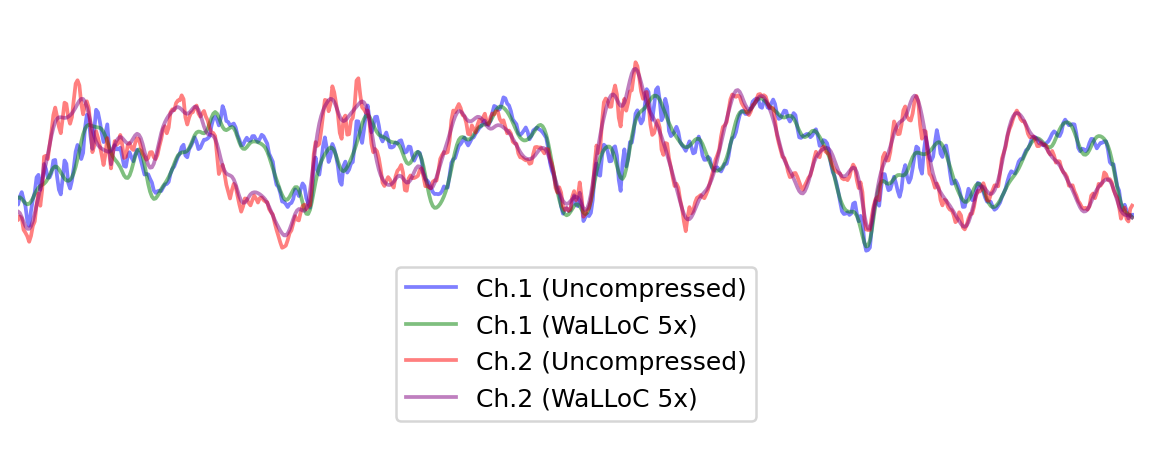

In [5]:
start, end = 0, 1000
fig = plt.figure(figsize=(8, 3), dpi=180)
plt.plot(x[0, start:end], alpha=0.5, c='b', label='Ch.1 (Uncompressed)')
plt.plot(x_hat[0, 0, start:end], alpha=0.5, c='g', label='Ch.1 (WaLLoC 5x)')
plt.plot(x[1, start:end], alpha=0.5, c='r', label='Ch.2 (Uncompressed)')
plt.plot(x_hat[0, 1, start:end], alpha=0.5, c='purple', label='Ch.2 (WaLLoC 5x)')

plt.xlim([400,1000])
plt.ylim([-0.6,0.3])
plt.legend(loc='lower center')
plt.box(False)
plt.xticks([])
plt.yticks([]);
fig.savefig("walloc_5x.svg")

In [6]:
codec_config = SimpleNamespace(**json.load(open("stereo_20x.json")))
checkpoint = torch.load("stereo_20x.pth",map_location="cpu",weights_only=False)
codec = walloc.Codec1D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode,
    post_filter = codec_config.post_filter
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec.eval();

In [7]:
with torch.no_grad():
    codec.eval()
    x_hat, _, _ = codec(x.unsqueeze(0))

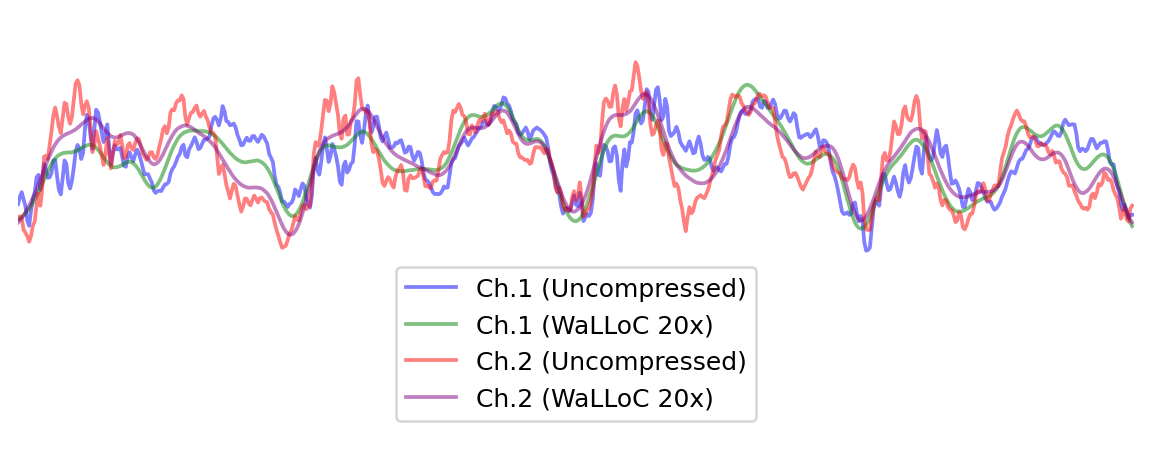

In [8]:
start, end = 0, 1000
fig = plt.figure(figsize=(8, 3), dpi=180)
plt.plot(x[0, start:end], alpha=0.5, c='b', label='Ch.1 (Uncompressed)')
plt.plot(x_hat[0, 0, start:end], alpha=0.5, c='g', label='Ch.1 (WaLLoC 20x)')
plt.plot(x[1, start:end], alpha=0.5, c='r', label='Ch.2 (Uncompressed)')
plt.plot(x_hat[0, 1, start:end], alpha=0.5, c='purple', label='Ch.2 (WaLLoC 20x)')

plt.xlim([400,1000])
plt.ylim([-0.6,0.3])
plt.legend(loc='lower center')
plt.box(False)
plt.xticks([])
plt.yticks([]);
fig.savefig("walloc_20x.svg")

In [9]:
codec = AutoencoderOobleck.from_pretrained(
    "stabilityai/stable-audio-open-1.0",
    subfolder='vae',
    torch_dtype=torch.float16
)
codec.eval();

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [10]:
def pad(audio, p=2**16):
    B,C,L = audio.shape
    padding_size = (p - (L % p)) % p
    if padding_size > 0:
        audio = torch.nn.functional.pad(audio, (0, padding_size), mode='constant', value=0)
    return audio

In [11]:
device="cuda"
codec = codec.to(device)
with torch.no_grad():
    L = x.shape[-1]
    x_padded = pad(x.unsqueeze(0), 2**16).to(device).to(torch.float16)
    z = codec.encode(x_padded).latent_dist.mode().to(torch.float16).to("cpu")
    x_hat = codec.decode(z.to(torch.float16).to(device)).sample
    x_hat = x_hat[0,:,:L].clamp(-0.5, 0.5)
    x_hat = x_hat.to(torch.float).to("cpu")

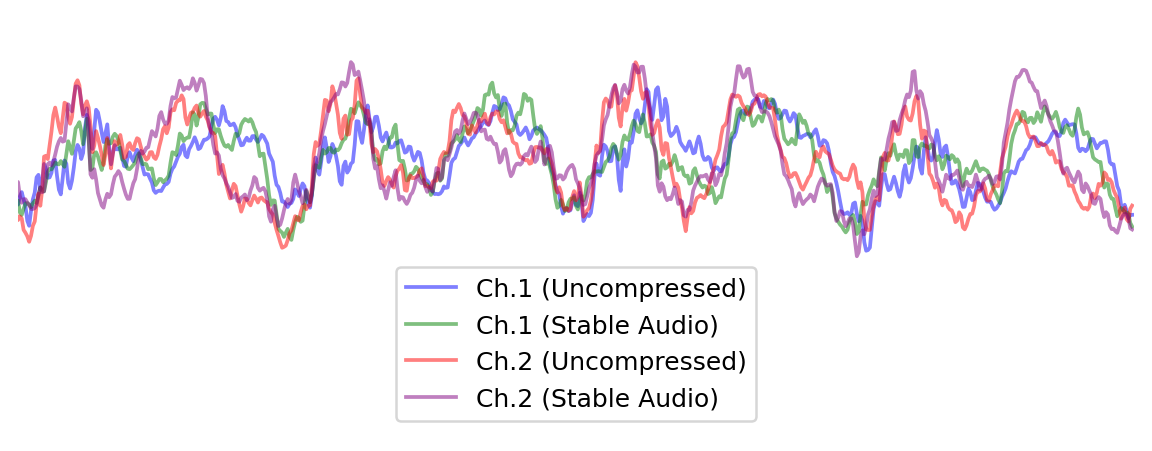

In [12]:
start, end = 0, 1000
fig = plt.figure(figsize=(8, 3), dpi=180)
plt.plot(x[0, start:end], alpha=0.5, c='b', label='Ch.1 (Uncompressed)')
plt.plot(x_hat[0, start:end], alpha=0.5, c='g', label='Ch.1 (Stable Audio)')
plt.plot(x[1, start:end], alpha=0.5, c='r', label='Ch.2 (Uncompressed)')
plt.plot(x_hat[1, start:end], alpha=0.5, c='purple', label='Ch.2 (Stable Audio)')

plt.xlim([400,1000])
plt.ylim([-0.6,0.3])
plt.legend(loc='lower center')
plt.box(False)
plt.xticks([])
plt.yticks([]);
fig.savefig("stable_audio.svg")

In [13]:
codec = EncodecModel.from_pretrained("facebook/encodec_48khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_48khz")
device = "cuda"
codec = codec.to(device)

/home/dan/g/lib/python3.12/site-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


In [14]:
with torch.no_grad():
        x_pre = torchaudio.transforms.Resample(fs,processor.sampling_rate)(2*x)
        x_pre = processor(raw_audio=x_pre, sampling_rate=processor.sampling_rate, return_tensors="pt")
        z = codec.encode(
            input_values = x_pre['input_values'].to(device),
            padding_mask = x_pre['padding_mask'].to(device),
            bandwidth=12.0,
        )
        z['audio_codes'] = z['audio_codes'].to("cpu")
        x_hat = codec.decode(
            audio_codes=z['audio_codes'].to(device),
            audio_scales=z['audio_scales'],
            padding_mask=x_pre['padding_mask']
        )['audio_values']
        x_hat = torchaudio.transforms.Resample(processor.sampling_rate,fs).to(device)(x_hat)
        x_hat = x_hat / 2
        x_hat = x_hat[0,:,:L].clamp(-0.5, 0.5)
        x_hat = x_hat.to("cpu")

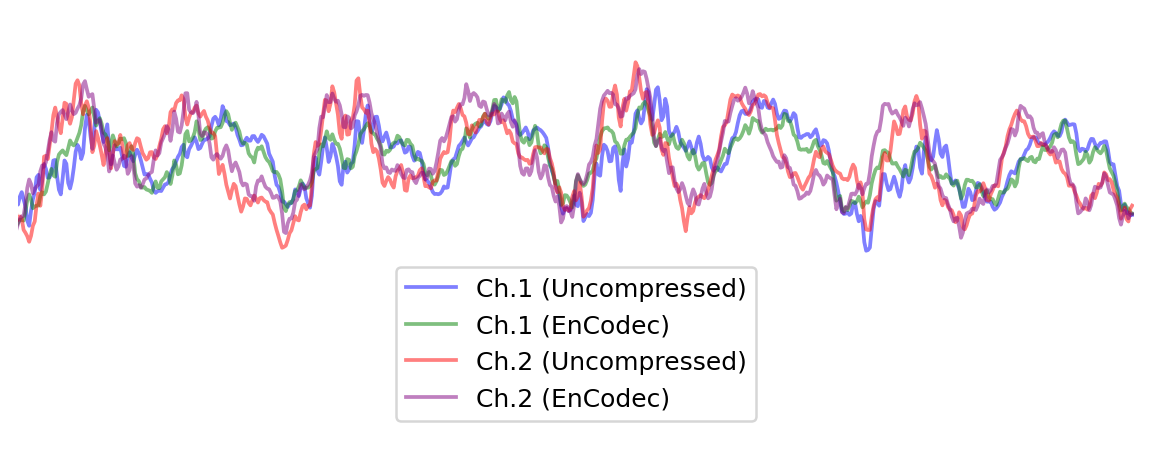

In [15]:
start, end = 0, 1000
fig = plt.figure(figsize=(8, 3), dpi=180)
plt.plot(x[0, start:end], alpha=0.5, c='b', label='Ch.1 (Uncompressed)')
plt.plot(x_hat[0, start:end], alpha=0.5, c='g', label='Ch.1 (EnCodec)')
plt.plot(x[1, start:end], alpha=0.5, c='r', label='Ch.2 (Uncompressed)')
plt.plot(x_hat[1, start:end], alpha=0.5, c='purple', label='Ch.2 (EnCodec)')

plt.xlim([400,1000])
plt.ylim([-0.6,0.3])
plt.legend(loc='lower center')
plt.box(False)
plt.xticks([])
plt.yticks([]);
fig.savefig("encodec.svg")